<h1 style="color:green; font-family:Georgia">
Machine Learning for MNIST Handwritten digit recognition with PyTorch ::
<hr>
</h1>

<span style = "font-family:Geogia; color:orange;  font-style:italic; font-size:14px">
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.<br>

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%<br>
</span>

<h5 style="color:red; font-family:Georgia">
total number of images (instances): 70000 <br>
total number of features: 784 (28$\times$28 pixels = 784)
</h5>


For reference of each step see: https://chatgpt.com/share/66ffe9c1-5f98-8013-83b4-e797970250ab

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Importing importent modules :
</h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
# from Curve_fitting_with_scipy import Gaussianfitting as Gf
# from Curve_fitting_with_scipy import Linefitting as Lf
from scipy.signal import fftconvolve
from collections import defaultdict
import PIL
import joblib
from tqdm import tqdm



from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression



from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier, XGBRFRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transformers
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Getting the data :
</h4>

In [2]:
file_path = "D:\\ML Dataset\\Kaggle handwritten alphabet a-z\\handwritten_data_785.csv"
# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

shuffled_index = np.random.permutation(data.shape[0])
data = data.iloc[shuffled_index]
del shuffled_index

data = data.iloc[:200000]
print(f"data shape: {data.shape}")

data shape: (200000, 785)


<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Separating out features and labels:
</h4>

In [3]:
train_percent = int(data.shape[0]*0.8)

data_train, data_test = data[:train_percent], data[train_percent:]
x_train = np.array(data_train.drop("0",axis=1))
y_train = np.array(data_train["0"])

x_test = np.array(data_test.drop("0",axis=1))
y_test = np.array(data_test["0"])

print(f"train shape: {data_train.shape}")

del data, data_train, data_test

train shape: (160000, 785)


<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Preprocessing with sklearn for imputing and scaling
</h4>

In [4]:
pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy='median')),
                    ('std_scalar',StandardScaler()),
                     # add as many as you want...
                    ])

x_train = pipeline.fit_transform(x_train)
x_test = pipeline.fit_transform(x_test)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Defining the neural network class:
</h4>

In [20]:
input_dimension = x_train[0].shape[0]
output_dimension = len(set(np.array(y_train)))

class FullyConnectedNN(nn.Module):
    global input_dimension
    global output_dimension
    
    def __init__(self, layer_dims):
        super(FullyConnectedNN, self).__init__()
        # Initialize a list to hold the layers
        self.layers = nn.ModuleList()
        
        # Input layer dimension
        in_dim = input_dimension  # Input size, e.g., for MNIST images : 784
        out_dim = output_dimension  # Output size, e.g., for MNIST images : 10
        
        # Create intermediate layers based on the provided dimensions
        for dim in layer_dims:
            self.layers.append(nn.Linear(in_dim, dim))
            in_dim = dim  # Update in_dim for the next layer
        # Output layer for 10 classes (digits 0-9)
        self.out = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = x.view(-1, input_dimension)
        # Pass the input through each layer
        for layer in self.layers:
            x = torch.relu(layer(x))  # Use ReLU activation
        # Get the output from the final layer
        x = self.out(x)
        return x



# Create a pipeline-like class
class TorchPipeline:
    def __init__(self, model, optimizer, criterion=nn.CrossEntropyLoss(),  
                 batch_size=64, epochs=5, learning_rate=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit(self, x_train, y_train, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), print_after=10):
        self.model.to(device)
        self.model.train()
        num_samples = x_train.size(0)

        # ANSI color codes
        # Foreground (text) colors
        BLACK = "\033[30m"
        RED = "\033[91m"
        GREEN = "\033[92m"
        YELLOW = "\033[93m"
        BLUE = "\033[94m"
        MAGENTA = "\033[95m"
        CYAN = "\033[96m"
        WHITE = "\033[97m"

        text_color = [RED,GREEN,YELLOW,BLUE,MAGENTA,CYAN,WHITE]

        # Background colors
        BG_BLACK = "\033[40m"
        BG_RED = "\033[41m"
        BG_GREEN = "\033[42m"
        BG_YELLOW = "\033[43m"
        BG_BLUE = "\033[44m"
        BG_MAGENTA = "\033[45m"
        BG_CYAN = "\033[46m"
        BG_WHITE = "\033[47m"

        # Reset color
        RESET = "\033[0m"

        for epoch in range(1, self.epochs + 1):
            # Initialize tqdm progress bar for the epoch
            C = text_color[epoch%len(text_color)-1]
            with tqdm(total=num_samples, desc=f'Epoch {epoch}/{self.epochs}', ncols=100, unit=" samples",
                     bar_format=f"{{l_bar}}{C}{{bar}}{RESET}|{{n_fmt}}/{{total_fmt}} [{GREEN}{{percentage:.0f}}%{RESET}]{{postfix}}") as pbar:
                for batch_start in range(0, num_samples, self.batch_size):
                    batch_end = min(batch_start + self.batch_size, num_samples)
                    data = x_train[batch_start:batch_end].to(device).float()
                    target = y_train[batch_start:batch_end].to(device)
    
                    # Zero the parameter gradients
                    self.optimizer.zero_grad()
    
                    # Forward pass
                    output = self.model(data)
    
                    # Calculate loss
                    loss = self.criterion(output, target)
    
                    # Backward pass and optimize
                    loss.backward()
                    self.optimizer.step()
    
                    # Update progress bar
                    pbar.update(batch_end - batch_start)
    
                    # Optionally print intermediate progress (e.g., after a certain number of batches)
                    if batch_start % (print_after * self.batch_size) == 0:
                        pbar.set_postfix({"Loss": f'{loss.item():.6f}'})
                print("==============================================================================\n")
                    
                    
    def predict(self, x_test, y_test, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.model.eval()  # Set model to evaluation mode
        num_samples = x_test.size(0)
        all_predictions = []  # To store all predicted labels
        correct = 0  # To count correct predictions

        with torch.no_grad():  # Disable gradient computation for prediction
            for batch_start in range(0, num_samples, self.batch_size):
                batch_end = min(batch_start + self.batch_size, num_samples)
                data = x_test[batch_start:batch_end].to(device).float()
                target = y_test[batch_start:batch_end].to(device)

                # Forward pass
                output = self.model(data)
                
                # Get the index of the max log-probability (prediction)
                pred = output.argmax(dim=1, keepdim=True)  # Shape: [batch_size, 1]
                all_predictions.append(pred.cpu().numpy())  # Store predictions
                
                # Count correct predictions
                correct += pred.eq(target.view_as(pred)).sum().item()

        # Concatenate all predictions into a single array
        all_predictions = np.concatenate(all_predictions)

        # Calculate accuracy
        accuracy = 100. * correct / num_samples
        print(f'\nTest set: Accuracy: {correct}/{num_samples} ({accuracy:.0f}%)\n')

        return all_predictions, accuracy

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Creating the model and hyperparameters
</h4>

In [21]:
# Initialize the model, loss function, optimizer, and pipeline
layer_dimensions = [512, 256, 128]  # Define your intermediate layer dimensions here
model = FullyConnectedNN(layer_dimensions)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
batch_size = 300
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Fitting the train data
</h4>

In [22]:
# Create the pipeline object
torchpipeline = TorchPipeline(model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         batch_size=batch_size, 
                         epochs=epochs)

In [15]:
# Fitting the model
torchpipeline.fit(x_train, y_train, print_after=25)

Epoch 1/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.130463


Epoch 2/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.085456


Epoch 3/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.051410


Epoch 4/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.049202


Epoch 5/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.060174


Epoch 6/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.041950


Epoch 7/10: 100%|███████████████████████████████████████████████|160000/160000 [100%], Loss=0.066158


Epoch 8/10:  97%|██████████████████████████████████████████████▍ |154800/160000 [97%], Loss=0.030429

In [16]:
# Making predictions
y_predict, accuracy = torchpipeline.predict(x_test, y_test, device)


Test set: Accuracy: 38924/40000 (97%)



accuracy_score:  97.31 %


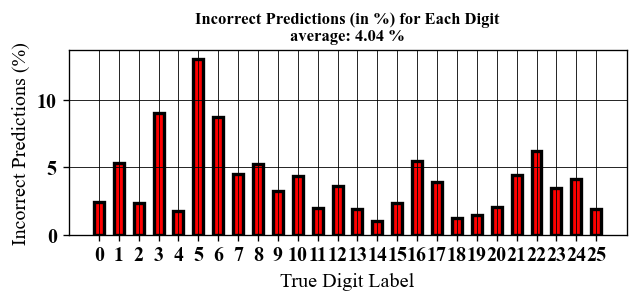

In [17]:
y_test_arr = np.array(y_test,dtype=np.int32)
y_predict = (np.array(y_predict)).reshape(y_test_arr.shape)

acc_score = accuracy_score(y_test_arr,y_predict)
print(f"accuracy_score:  {100*acc_score:.2f} %")

# Identify incorrect predictions
incorrect_indices = np.where(y_test_arr != y_predict)[0]
incorrect_labels = y_test[incorrect_indices]# Extract the corresponding true labels (y_test) for incorrect predictions
total_per_digit = np.bincount(sorted(y_test_arr), minlength=10) # Calculate the total occurrences of each digit in the test set
incorrect_per_digit = np.bincount(sorted(incorrect_labels), minlength=10)  # Calculate the incorrect occurrences for each digit
percentage_incorrect_per_digit = (incorrect_per_digit / total_per_digit) * 100  # Calculate the percentage of incorrect predictions for each digit

# Plot the percentage of incorrect predictions for each digit
plt.figure(figsize=(6,2))
plt.bar(np.arange(output_dimension), percentage_incorrect_per_digit, color='red', edgecolor='black', linewidth = 2, width=0.5)
plt.xticks(np.arange(output_dimension))  # Digits 0 to 9
plt.xlabel('True Digit Label')
plt.ylabel('Incorrect Predictions (%)')
plt.title('Incorrect Predictions (in %) for Each Digit\n'+f"average: {np.mean(percentage_incorrect_per_digit):.2f} %", fontsize=10, fontweight='bold')
plt.grid(True, lw=0.5, color = 'k')
plt.show()

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Showing a random example
</h4>

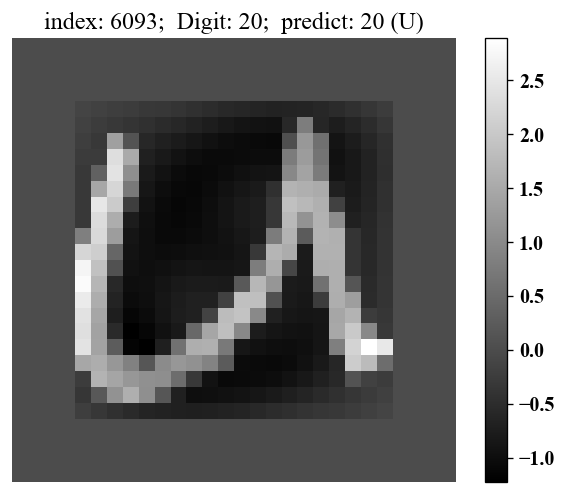

In [11]:
index = np.random.randint(len(y_test_arr)-1)

@np.vectorize
def n_th_alphabet(n):
    if(0<=n<=25):
        return chr(65+n)
    else:
        pass

random_image = np.array((x_test[index])).reshape(28,28)
# print(random_image)
plt.imshow(random_image, cmap='gray')
plt.colorbar()
plt.axis("off")
plt.title(f"index: {index};  Digit: {y_test_arr[index]};  predict: {y_predict[index]} ({n_th_alphabet(y_predict[index])})")
plt.show()